In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

# 마케팅 캠페인 데이터셋
* 어떤 특성(피처)을 가진 소비자가 마케팅 캠페인에 더 많이 참여했는지 분석하고자 합니다
* (참고) [캐글](https://www.kaggle.com/rodsaldanha/arketing-campaign) 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
base_path = "/content/drive/MyDrive/2022-1학기 DSL 정규세션/[220215] Unsupervised Learning"
marketing = pd.read_csv(base_path + "/marketing_campaign.csv", sep =';')

In [9]:
marketing.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0


### 전처리
* (참고) [EDA B조 코드](https://github.com/yonsei-dsl/7th_EDA/blob/main/B%EC%A1%B0/EDA_B%EC%A1%B0_%EC%BD%94%EB%93%9C.ipynb) - 감사합니다 :)

In [10]:
# company에 enrol한 연도, 월 따로 저장
marketing.Dt_Customer = pd.to_datetime(marketing.Dt_Customer)
marketing["enrol_year"] = marketing.Dt_Customer.dt.strftime("%Y")
marketing["enrol_month"] = marketing.Dt_Customer.dt.strftime("%m")

In [13]:
from datetime import datetime
# 현재까지의 회원일수 따로 저장
y = pd.to_datetime(datetime.today().strftime("%Y-%m-%d"))

In [18]:
marketing['days'] = y - marketing.Dt_Customer
marketing['days'] = marketing['days'] / np.timedelta64(1, 'D')
marketing['days'] = marketing['days'].astype(int) # int형으로 변환

In [19]:
# 나이를 age에 저장
marketing['age'] = 2022-marketing['Year_Birth']

In [20]:
marketing.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'enrol_year', 'enrol_month', 'days', 'age'],
      dtype='object')

5차례의 마케팅 캠페인에 총 몇 회 참여했는지에 따라 소비자 군집을 만들고자 합니다 \
 

In [24]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

In [28]:
# 소비자별 총 캠페인 참여 횟수를 구하여 CampaignAttendance에 저장
# (힌트) 'AcceptedCmpN'의 자료형은 ?!
marketing['CampaignAttendance'] = marketing['AcceptedCmp1'] +  marketing['AcceptedCmp2'] + marketing['AcceptedCmp3'] +  marketing['AcceptedCmp4'] +  marketing['AcceptedCmp5'] 

In [29]:
# 5번의 마케팅 캠페인 모두에 참여한 소비자는 없음
marketing['CampaignAttendance'].unique()

array([0, 1, 2, 3, 4])

분석을 위해 **연속형 변수**만을 피처로 사용하겠습니다
* (참고) https://www.kaggle.com/ededhiscalifh/marketing-campaign-eda-practice/notebook

In [30]:
ID = ['ID']
features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
label = ['CampaignAttendance'] 

In [31]:
print(len(features),"차원 데이터입니다")

15 차원 데이터입니다


In [32]:
campaign = marketing[ID + features + label]

In [33]:
# 결측값 제거
campaign = campaign.dropna(how='any',axis=0) 

In [34]:
campaign.shape 

(2216, 17)

In [36]:
campaign.head(3)

,ID,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,CampaignAttendance
0,5524,3457,65,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0
1,2174,2907,68,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0
2,4141,3106,57,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0


# PCA
* 클러스터링을 수행하기 전에 PCA를 사용해 추후 클러스터링 단계에서 사용할 주성분 개수를 구하도록 하겠습니다
* 주성분 개수는 분산 설명 비율이 90% 이상이 되게끔 하는 값으로 구하겠습니다

In [37]:
# 데이터프레임의 형태로 피처셋과 레이블셋을 할당해주세요
X = campaign.loc[:, ~campaign.columns.isin(['CampaignAttendance'])]
y =  campaign['CampaignAttendance']

In [42]:
# Scaling 먼저 해주세요
from sklearn.preprocessing import StandardScaler

# StandardScaler객체 생성
scaler = StandardScaler()
# StandardScaler 로 데이터 셋 변환. fit( ) 과 transform( ) 호출.  
scaler.fit(X)
X_std = scaler.transform(X)


# 시각화 위해 데이터프레임으로 변환
X_std = pd.DataFrame(X_std, columns=X.columns, index=list(X.index.values))


In [43]:
X_std

,ID,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,-0.019809,1.529129,0.986443,0.234063,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,0.351713,1.428553,2.504712,-0.554143,0.693232
1,-1.051009,-1.188411,1.236801,-0.234559,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,-0.168231,-1.125881,-0.571082,-1.169518,-0.131574
2,-0.445526,-0.205155,0.318822,0.769478,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,-0.688176,1.428553,-0.229327,1.291982,-0.543978
3,0.182737,-1.059945,-1.266777,-1.017239,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,-0.168231,-0.760962,-0.912837,-0.554143,0.280829
4,-0.081373,-0.951244,-1.016420,0.240221,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,1.391603,0.333796,0.112428,0.061232,-0.131574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1.625801,0.135772,0.151917,0.356642,-0.104093,1.197646,0.418348,0.066913,0.079693,2.215416,3.919308,-0.168231,1.793473,0.112428,-0.554143,-0.131574
2236,-0.488620,-1.652863,1.904422,0.467539,0.241428,0.299208,-0.662463,-0.610954,-0.687574,-0.658233,-0.694260,2.431492,1.428553,-0.229327,-0.246455,0.693232
2237,0.517646,-0.980889,-1.016420,0.188091,1.450751,1.787710,0.544024,0.223001,-0.102990,-0.365998,-0.385402,-0.688176,-0.760962,0.112428,2.215044,0.280829
2238,0.814693,-0.975948,1.069896,0.675388,-1.417072,0.364441,0.091591,0.209622,0.773887,0.072356,0.328832,-0.168231,0.698715,0.795937,1.291982,-0.956381


원본 차원의 수만큼 총 15개의 주성분을 생성하겠습니다

In [44]:
from sklearn.decomposition import PCA

pca =  PCA(n_components=15)
pca.fit(X_std) # PCA에는 scaling한 데이터를 넣어주어야 합니다
X_pca = pca.transform(X_std)

In [62]:
X_pca.shape

(2216, 15)

In [45]:
# 데이터프레임 변환
X_pca = pd.DataFrame(data=X_pca) 

In [46]:
# 100%가 되어야 합니다
print("15개의 주성분에 의해 설명되는 분산 비율: ", sum(pca.explained_variance_ratio_))

15개의 주성분에 의해 설명되는 분산 비율:  0.9865634280023452


In [47]:
# 15개의 주성분을 중요도 순으로 나열합니다
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)

총 분산의 90%이상을 잡아내는 주성분의 개수를 구하세요!
* 이후 클러스터링 학습 시 해당 개수만큼 차원 축소한 피처셋을 이용할 겁니다

In [52]:
# 처음 N개 주성분의 중요도
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('처음 2개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:1].sum(axis=1).values)
print('처음 3개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:2].sum(axis=1).values)
print('처음 10개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('처음 12개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:11].sum(axis=1).values)
print('처음 13개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:12].sum(axis=1).values)
print('처음 14개의 주성분에 의해 설명되는 분산 비율: ',
      importanceOfPrincipalComponents.loc[:,0:13].sum(axis=1).values)

처음 2개의 주성분에 의해 설명되는 분산 비율:  [0.46618847]
처음 3개의 주성분에 의해 설명되는 분산 비율:  [0.53903776]
처음 10개의 주성분에 의해 설명되는 분산 비율:  [0.87437521]
처음 12개의 주성분에 의해 설명되는 분산 비율:  [0.92728357]
처음 13개의 주성분에 의해 설명되는 분산 비율:  [0.95147919]
처음 14개의 주성분에 의해 설명되는 분산 비율:  [0.97107798]


In [53]:
# 처음 두 개의 주성분을 이용하여 2차원 평면에 데이터셋의 분포를 나타내겠습니다
def scatterPlot(xDF, yDF):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index) 
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    plt.show()

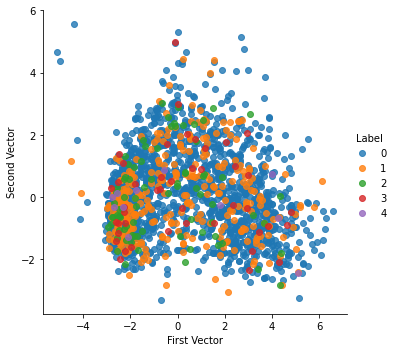

In [54]:
# 설명력이 별로군여 ㅠㅅㅠ
scatterPlot(X_pca, y)

# 클러스터링
* PCA를 통해 구한 상위 $x$개(분산 설명력 90% 이상)의 주성분을 사용하여 클러스터링을 하고자 합니다

In [55]:
from sklearn.cluster import KMeans

In [56]:
# 파라미터를 설정해주세요
n_clusters = 5 # 군집수
n_init = 4 # 초기화 횟수
max_iter = 300  # 학습(군집 재할당)의 반복 횟수
tol = 0.001 # 너무 오랜 시간 반복하는 경우에 대비해 tol만큼 줄어들지 않으면 조기 종료
random_state = 42

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
      max_iter=max_iter, tol=tol, random_state=random_state)

In [57]:
N=10

In [59]:
# 처음 N개의 주성분만을 이용하고자 합니다
cutoff = N-1 # 앞서 구한 주성분 개수 - 1
X_train_Kmeans = X_pca.loc[:,0:cutoff]
print(X_train_Kmeans)

             0         1         2  ...         7         8         9
0     3.792432  1.441846 -1.188708  ...  0.902760  0.257939  2.130698
1    -2.116525 -1.188087  1.428016  ...  0.463269  0.289036  0.246980
2     1.667846 -0.044313  0.500361  ... -0.913294 -1.059667 -0.448627
3    -2.376262 -1.001722 -0.552789  ...  0.041859 -0.125810 -0.049045
4    -0.066335  0.124804 -0.202264  ...  1.176385 -0.433120  0.011208
...        ...       ...       ...  ...       ...       ...       ...
2211  2.627261  1.143630 -0.701835  ... -1.832286  1.289507  1.045767
2212 -0.789130  1.770798  2.991630  ...  1.160588 -0.470277  0.945593
2213  1.031464 -0.597690  0.110505  ... -0.854696 -0.871251 -1.051934
2214  1.882094 -0.471917  1.509447  ... -0.063488 -0.014604 -0.321838
2215 -1.562218  0.924936  0.557358  ...  0.314076  0.096718 -0.260834

[2216 rows x 10 columns]


In [63]:
 kmeans.fit(X_train_Kmeans)

KMeans(n_clusters=5, n_init=4, random_state=42, tol=0.001)

In [64]:
kmeans.labels_

array([3, 4, 0, ..., 0, 0, 1], dtype=int32)

In [65]:
# 클러스터링 결과 
result = X_train_Kmeans.copy()

result["cluster"] =  kmeans.labels_

In [66]:
result.head()

,0,1,2,3,4,5,6,7,8,9,cluster
0,3.792432,1.441846,-1.188708,-0.267356,-0.450181,-1.670218,0.680131,0.902760,0.257939,2.130698,3
1,-2.116525,-1.188087,1.428016,-0.585560,0.974661,-0.775770,0.039491,0.463269,0.289036,0.246980,4
2,1.667846,-0.044313,0.500361,0.385875,0.997256,-0.233787,-0.368134,-0.913294,-1.059667,-0.448627,0
3,-2.376262,-1.001722,-0.552789,0.678006,0.629780,0.761089,-0.580799,0.041859,-0.125810,-0.049045,4
4,-0.066335,0.124804,-0.202264,-1.118983,-0.653129,1.295920,-1.341627,1.176385,-0.433120,0.011208,2


In [68]:
def ClusteringPlot(xDF):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,xDF["cluster"]), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "cluster"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="cluster", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    plt.show()

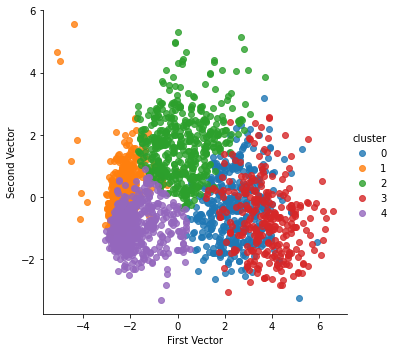

In [69]:
ClusteringPlot(result)

결과물에 대한 해석 한두줄 

실제 값에 애초에 패턴이 없으므로 k means를 해도 결과는 같다. 